In [1]:
import gym
import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

matplotlib.style.use('ggplot')

In [2]:
def plot_value_function(V, title):
    """Plots the value function as a surface plot.
        input: V (defaultdict[(palyer, dealer, ace)] = value), title
    """
    "1.确定绘图空间的大小（x，y坐标的最大最小值）"
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    "2.得到网格点坐标"
    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title=None):
        fig = plt.figure(figsize=(20, 10), facecolor='white')

        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        if title: ax.set_title(title)
        ax.view_init(ax.elev, -120)
        ax.set_facecolor("white")
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "(No Usable Ace)")
    plot_surface(X, Y, Z_ace, "(Usable Ace)")

In [19]:
def epsilon_greddy_policy(state_action_values, epsilon = 0.1):
    """
        input: state_action_values (np(nA)), state, epsilon
        return: policy (np(nA))
    """
    nA = state_action_values.shape[0]
    policy = np.ones((nA), dtype=np.float32) * (epsilon / nA)
    optim_action = np.argmax(state_action_values)
    policy[optim_action] = 1 - epsilon + epsilon / nA
    return policy

In [20]:
def mc_control_trajectory_collect(episode_trajectory, values_sum, values_count, discount=1.0, is_first= True):
    trajectory_len = len(episode_trajectory)
    gains = np.zeros(trajectory_len+1, dtype=np.float32)
    "1.一遍计算当前经验轨迹所有时刻的收益值: gain[i] = reward + discount * gain[i+1]"
    for i, data_i in enumerate(reversed(episode_trajectory)): # data_i : ((s, a), r)
        i = trajectory_len - i - 1 # i = 0时，实际上i对应的下标为len-i-1
        gains[i] = data_i[1] + discount * gains[i+1]
    "2.收集"
    if(is_first):
        "首次访问"
        sa_set = set()
        for i, data_i in enumerate(episode_trajectory):
            sa_pair = data_i[0]
            if(sa_pair in sa_set):
                continue
            sa_set.add(state)
            values_sum[sa_pair] += gains[i]
            values_count[sa_pair] += 1.0
    else:
        "每次访问"
        for i, data_i in enumerate(episode_trajectory):
            sa_pair = data_i[0]
            values_sum[sa_pair] += gains[i]
            values_count[sa_pair] += 1.0

In [30]:
def mc_everyvisit_epsilon_greddy_control(environment, max_episodes=1000, epsilon=0.1, episode_endtime=10, discount=1.0):
    """蒙特卡洛-每次访问-epsilon贪婪控制算法
        input: environment, epsilon=0.1, max_episodes=100, episode_endtime=10, discount=1.0
        return: action_values (nS, nA)
    """
    env = environment
    trajectory_collect = mc_control_trajectory_collect
    nA = env.action_space.n
    action_values = defaultdict(lambda: np.zeros(nA)) # 每个动作价值函数默认为一个np数组（长度为nA）
    values_sum = defaultdict(float)
    values_count = defaultdict(float)
    
    "对每一幕而言"
    for episode in range(max_episodes):
        episode_trajectory = []
        state = env.reset()
        "1.使用策略生成经验轨迹"
        for i in range(episode_endtime):
            "1.1按照epsilon贪婪选择当前的动作"
            action_prob = epsilon_greddy_policy(action_values[state], nA, epsilon)
            action = np.random.choice(np.arange(action_prob.shape[0]),p=action_prob) # 按照相应的概率选择元素
            "1.2完成一个动作"
            next_state, reward, done, _ = env.step(action)
            episode_trajectory.append(((state, action), reward)) # ((s ,a), r)
            if(done):
                break
            state = next_state

        "2.使用每次访问算法收集经验轨迹中的数据"
        trajectory_collect(episode_trajectory, values_sum, values_count, discount, is_first= False)
        "3.平均化处理，并赋值到动作价值函数。（每一幕结束前都要重新赋值，因为在之后的一幕中会用到更新后的动作价值函数）"
        for sa_pair in values_sum:
            action_values[sa_pair[0]][sa_pair[1]] = values_sum[sa_pair] / values_count[sa_pair]
        
    return action_values

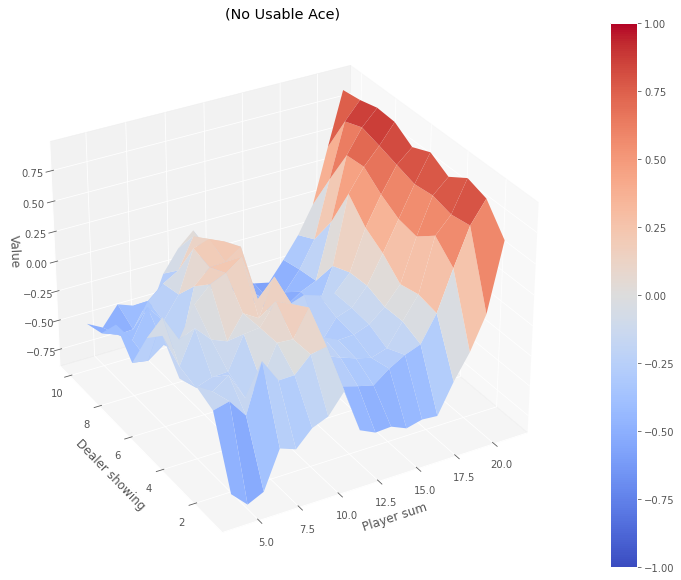

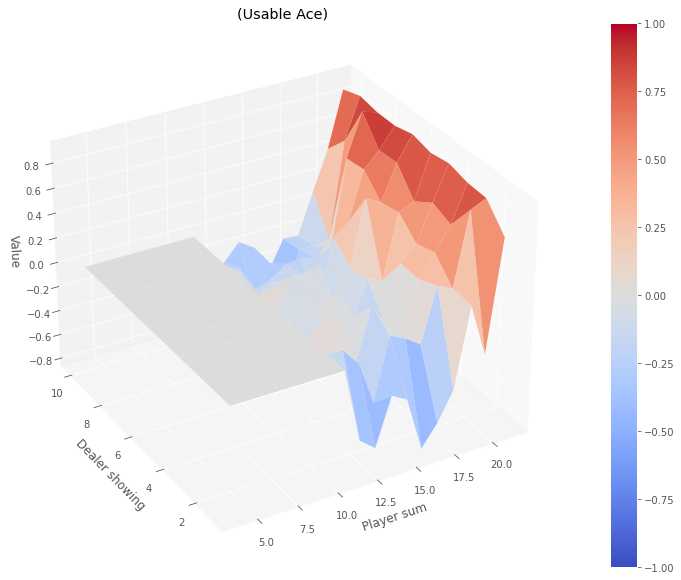

In [36]:
env = gym.make("Blackjack-v0")
action_values = mc_everyvisit_epsilon_greddy_control(env, 50000)

v1 = defaultdict(float)
for state, state_action_values in action_values.items():
    v1[state] = np.max(state_action_values)

plot_value_function(v1, title="mc_firstvisit_control_epsilon_greddy")

In [37]:
for key, item in sorted(v1.items()):
    print(key, item)

(4, 1, False) -0.7272727272727273
(4, 1, True) 0.0
(4, 2, False) -0.18181818181818182
(4, 2, True) 0.0
(4, 3, False) -0.11538461538461539
(4, 3, True) 0.0
(4, 4, False) -0.18518518518518517
(4, 4, True) 0.0
(4, 5, False) 0.034482758620689655
(4, 5, True) 0.0
(4, 6, False) -0.1111111111111111
(4, 6, True) 0.0
(4, 7, False) -0.4444444444444444
(4, 7, True) 0.0
(4, 8, False) -0.25
(4, 8, True) 0.0
(4, 9, False) -0.4482758620689655
(4, 9, True) 0.0
(4, 10, False) -0.49333333333333335
(4, 10, True) 0.0
(5, 1, False) -0.8571428571428571
(5, 1, True) 0.0
(5, 2, False) -0.14814814814814814
(5, 2, True) 0.0
(5, 3, False) -0.2
(5, 3, True) 0.0
(5, 4, False) -0.3
(5, 4, True) 0.0
(5, 5, False) -0.2558139534883721
(5, 5, True) 0.0
(5, 6, False) 0.023255813953488372
(5, 6, True) 0.0
(5, 7, False) -0.4666666666666667
(5, 7, True) 0.0
(5, 8, False) -0.4186046511627907
(5, 8, True) 0.0
(5, 9, False) -0.5
(5, 9, True) 0.0
(5, 10, False) -0.5641025641025641
(5, 10, True) 0.0
(6, 1, False) -0.79411764705